# Benchmarking QSiLUApprox in YOLOv5
**Objective:** Evaluate the accuracy impact of replacing SiLU activation with QSiLUApprox in YOLOv5.


In [2]:
# if you are in colab
!git clone https://github.com/BoumedineBillal/silu_quantizer.git
%cd silu_quantizer/notebooks
!pip install ultralytics

^C
[WinError 2] The system cannot find the file specified: 'silu_quantizer/notebooks'
c:\Users\orani\bilel\Projects\p_2025\esp32p4dl_pip\pytorch_lab\version1\quantizer\silu_quantizer\notebooks


Cloning into 'silu_quantizer'...
error: RPC failed; curl 92 HTTP/2 stream 5 was not closed cleanly: CANCEL (err 8)
error: 4902 bytes of body are still expected
fetch-pack: unexpected disconnect while reading sideband packet
fatal: early EOF
fatal: fetch-pack: invalid index-pack output


In [1]:
import sys
import os

# Get the absolute path of f2
src_path = os.path.abspath("../src")  
# Add it to sys.path
sys.path.append(src_path)

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import platform
import psutil
from ultralytics import YOLO

# Custom modules
from quantization.quantization_tools import QuantizeActivation, test_quantization, get_qstat
from approximation.act_approximation_tools import SiluApproximation, test_silu_approximation
from QSiLUApprox.QSiLUApprox import QSiLUApprox
from utils.module_replacer import replace_module

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Get CPU information
cpu_name = platform.processor()
cpu_cores = psutil.cpu_count(logical=False)  # Physical cores
cpu_threads = psutil.cpu_count(logical=True)  # Logical cores

# Get RAM information
ram_info = psutil.virtual_memory()
total_ram = ram_info.total / (1024**3)  # Convert bytes to GB

# Get GPU information (if available)
if device == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # Convert bytes to GB
    print(f"GPU: {gpu_name} ({gpu_memory:.2f} GB)")
else:
    gpu_name = "No GPU"
    gpu_memory = 0

# Print system specs
print("\n--- System Information ---")
print(f"CPU: {cpu_name} ({cpu_cores} cores, {cpu_threads} threads)")
print(f"RAM: {total_ram:.2f} GB")
print(f"GPU: {gpu_name}")


Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU (8.00 GB)

--- System Information ---
CPU: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel (14 cores, 20 threads)
RAM: 63.69 GB
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Load YOLOv5 Model

In [3]:
# Load the pre-trained YOLOv5n model
model = YOLO('yolov5n.pt').eval().to(device)

# Run baseline evaluation (without modification)
print("\n--- Evaluating Original Model ---\n")
baseline_results = model.val(
    data='coco.yaml',
    batch=32,
    imgsz=640,
    device=device,
    half=True,
    workers=14
)

# Store baseline metrics
baseline_map50 = baseline_results.box.map50
baseline_map = baseline_results.box.map
baseline_latency = baseline_results.speed["inference"]

PRO TIP  Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


--- Evaluating Original Model ---

Ultralytics 8.3.72  Python-3.9.21 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv5n summary (fused): 193 layers, 2,649,200 parameters, 0 gradients, 7.7 GFLOPs


val: Scanning C:\Users\orani\OneDrive\Desktop\bilel\Projects\p_2025\esp32p4dl_pip\pytorch_lab\version1\yolov5\datasets\coco\labels\val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:27<00:00,  5.75it/s]


                   all       5000      36335        0.6      0.453      0.492      0.341
                person       2693      10777      0.723      0.662      0.726      0.491
               bicycle        149        314      0.621      0.382      0.422      0.234
                   car        535       1918      0.628      0.507      0.541      0.342
            motorcycle        159        367      0.699      0.578      0.647      0.386
              airplane         97        143      0.765      0.762      0.819      0.634
                   bus        189        283       0.75      0.664      0.726      0.591
                 train        157        190      0.754      0.774      0.817      0.615
                 truck        250        414      0.546      0.386      0.443      0.282
                  boat        121        424      0.551      0.306      0.352      0.191
         traffic light        191        634      0.571      0.323      0.377      0.194
          fire hydran

## Replace SiLU with QSiLUApprox

In [4]:
# Load the pre-trained YOLOv5n model
model = YOLO('yolov5n.pt').eval().to(device)

print("\n--- Replacing SiLU with QSiLUApprox ---\n")
replace_module(model.model, nn.SiLU, QSiLUApprox, ["act"])

PRO TIP  Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


--- Replacing SiLU with QSiLUApprox ---

Replacing model.0.act: SiLU → QSiLUApprox
Replacing model.1.act: SiLU → QSiLUApprox
Replacing model.2.cv1.act: SiLU → QSiLUApprox
Replacing model.2.cv2.act: SiLU → QSiLUApprox
Replacing model.2.cv3.act: SiLU → QSiLUApprox
Replacing model.2.m.0.cv1.act: SiLU → QSiLUApprox
Replacing model.2.m.0.cv2.act: SiLU → QSiLUApprox
Replacing model.3.act: SiLU → QSiLUApprox
Replacing model.4.cv1.act: SiLU → QSiLUApprox
Replacing model.4.cv2.act: SiLU → QSiLUApprox
Replacing model.4.cv3.act: SiLU → QSiLUApprox
Replacing model.4.m.0.cv1.act: SiLU → QSiLUApprox
Replacing model.4.m.0.cv2.act: SiLU → QSiLUApprox
Replacing model.4.m.1.cv1.act: SiLU → QSiLUApprox
Replacing model.4.m.1.cv2.act: SiLU → QSiLUApprox


## Evaluate Modified Model

In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [6]:
print("\n--- Evaluating Modified Model ---\n")
modified_results = model.val(
    data='coco.yaml',
    batch=32,
    imgsz=640,
    device=device,
    half=True,
    workers=14
)

# Store modified model metrics
modified_map50 = modified_results.box.map50
modified_map = modified_results.box.map
modified_latency = modified_results.speed["inference"]


--- Evaluating Modified Model ---

Ultralytics 8.3.72  Python-3.9.21 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv5n summary (fused): 468 layers, 2,649,200 parameters, 0 gradients, 7.7 GFLOPs


val: Scanning C:\Users\orani\OneDrive\Desktop\bilel\Projects\p_2025\esp32p4dl_pip\pytorch_lab\version1\yolov5\datasets\coco\labels\val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


                   all       5000      36335      0.574      0.429      0.458      0.309
                person       2693      10777       0.69      0.655      0.704      0.466
               bicycle        149        314      0.534      0.404      0.394       0.21
                   car        535       1918      0.612      0.494      0.515      0.321
            motorcycle        159        367      0.694      0.514      0.612      0.351
              airplane         97        143      0.747      0.727      0.769      0.578
                   bus        189        283       0.75      0.592      0.698      0.549
                 train        157        190      0.766      0.716      0.787      0.581
                 truck        250        414      0.554      0.401      0.422      0.255
                  boat        121        424      0.495      0.293       0.32       0.16
         traffic light        191        634       0.59      0.287       0.35      0.178
          fire hydran

## Results Comparison


--- Benchmark Results ---

Model: yolov5n
Baseline Activation: SiLU (float operations)
Modified Activation: QSiLUApprox (int16 operations)
mAP@0.5 (Baseline): 0.4917
mAP@0.5 (Modified): 0.4583
mAP@0.5:0.95 (Baseline): 0.3408
mAP@0.5:0.95 (Modified): 0.3091


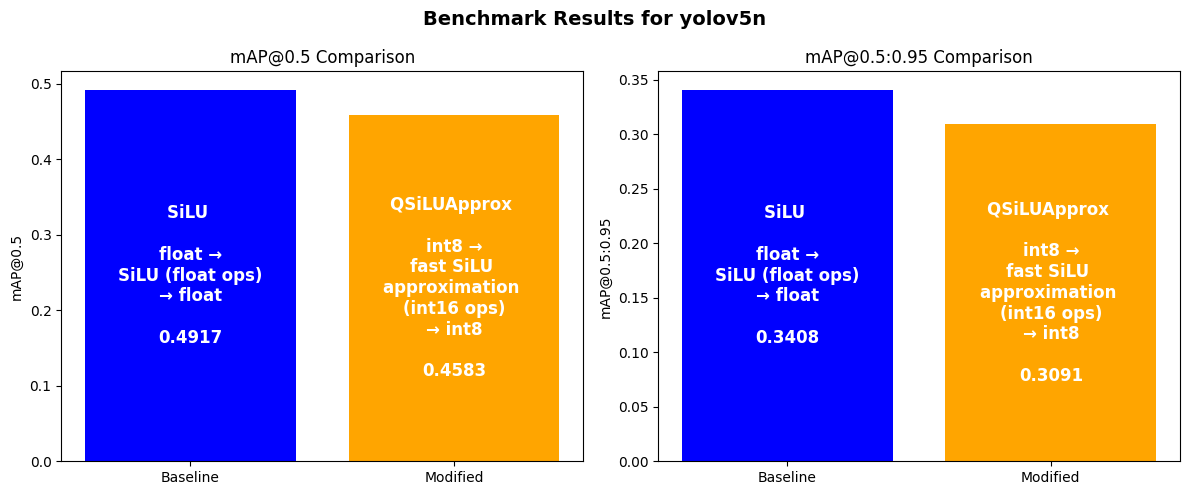

In [7]:
import matplotlib.pyplot as plt
import os

# Extract model name (e.g., "yolov5n", "yolov8s", etc.)
model_name = os.path.splitext(model.model.args.get('model', 'Unknown YOLO Model'))[0]

# Print benchmark results
print("\n--- Benchmark Results ---\n")
print(f"Model: {model_name}")
print(f"Baseline Activation: SiLU (float operations)")
print(f"Modified Activation: QSiLUApprox (int16 operations)")
print(f"mAP@0.5 (Baseline): {baseline_map50:.4f}")
print(f"mAP@0.5 (Modified): {modified_map50:.4f}")
print(f"mAP@0.5:0.95 (Baseline): {baseline_map:.4f}")
print(f"mAP@0.5:0.95 (Modified): {modified_map:.4f}")

# Ensure inline plotting
%matplotlib inline

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Benchmark Results for {model_name}", fontsize=14, fontweight="bold")  # Add model name to title

# Data
labels = ["Baseline", "Modified"]
colors = ['blue', 'orange']
map50_values = [baseline_map50, modified_map50]
map95_values = [baseline_map, modified_map]
activation_labels = [
    "SiLU \n\nfloat →\nSiLU (float ops)\n→ float\n", 
    "QSiLUApprox \n\nint8 →\nfast SiLU \napproximation \n(int16 ops)\n→ int8\n"
]

# mAP@0.5 comparison
bars1 = ax[0].bar(labels, map50_values, color=colors)
ax[0].set_title("mAP@0.5 Comparison")
ax[0].set_ylabel("mAP@0.5")

# Annotate inside the bars
for bar, value, act_label in zip(bars1, map50_values, activation_labels):
    ax[0].text(bar.get_x() + bar.get_width()/2, value/2,  
               f"{act_label}\n{value:.4f}", 
               ha='center', va='center', fontsize=12, color='white', fontweight='bold')

# mAP@0.5:0.95 comparison
bars2 = ax[1].bar(labels, map95_values, color=colors)
ax[1].set_title("mAP@0.5:0.95 Comparison")
ax[1].set_ylabel("mAP@0.5:0.95")

# Annotate inside the bars
for bar, value, act_label in zip(bars2, map95_values, activation_labels):
    ax[1].text(bar.get_x() + bar.get_width()/2, value/2,  
               f"{act_label}\n{value:.4f}", 
               ha='center', va='center', fontsize=12, color='white', fontweight='bold')

# Improve layout
plt.tight_layout()
plt.show()


## Conclusion

In [8]:
print("\n--- Summary ---\n")

if modified_map50 >= baseline_map50:
    print("✅ The modified model maintains or improves accuracy.")
else:
    print("ℹ️ The modified model has a slight accuracy drop, but this is expected due to int8 quantization without retraining.")

print("\n📌 This result is promising, considering the computational benefits of integer operations.")
print("Further fine-tuning or retraining could help recover the small accuracy gap.")



--- Summary ---

ℹ️ The modified model has a slight accuracy drop, but this is expected due to int8 quantization without retraining.

📌 This result is promising, considering the computational benefits of integer operations.
Further fine-tuning or retraining could help recover the small accuracy gap.
